# Modelo de aprendizaje automático usado como herramienta para ayudar a predecir la mora Crediticia

---

Científico de datos.  __Databiz__
> __Johan S. Méndez__


# Librerias Necesarias para el desarrollo 


In [60]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import spearmanr, chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (mean_squared_log_error, 
                             mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             accuracy_score,
                             recall_score,
                             f1_score, precision_score,
                             plot_confusion_matrix,
                             roc_curve, auc,confusion_matrix,
                             cohen_kappa_score
                            )

import xgboost as xgb
from xgboost import plot_importance
from xgboost import XGBClassifier

# Modulos Escritos
import connect_database
import Data_cleaning
import parameter_reduction
import models
import split_data

# Análisis datos

Se hace la lectura de la base de datos utilizando el módulo _connect_ que se encuentra escrito dentro del archivo __connect_database.py__. Con esto se esta
blece la conexión SQL a las bases guardadas en azure. A continuación se lista la base a la cual se quiere hacer la conexión 

In [6]:
# Credenciales
server   = "carterasvr.database.windows.net"
database = "cartera"
username = "consulta"
password = "D4t4b1z2.123"

# Se establece la conexión 
cnxn = connect_database.connect(server, database, username, password)

Se hace la petición SQL que se va a trabajar para responder la pregunta propuesta

In [7]:
sql = ("SELECT * FROM HIST_CARTERA")

data_source = pd.read_sql(sql, cnxn)

Se hace una mirada a los datos, utilizando una variable auxiliar para guardar los datos y no hacer lecturas en cada modificación  

In [144]:
data_source = pd.read_pickle("data.ftr")
data = data_source.copy()
data

,ID_FECHA_CONSULTADA,ANIO_CARTERA,MES_CARTERA,ANIOMES_CARTERA,NUMERO_CONTRATO,TIPO_IDENTIFICACION,IDENTIFICACION,SEXO,INGRESO,REPUTACION_CLIENTE,...,CANTIDAD_FACTURAS_CON_MORA,FECHA_REGISTRO_CARTERA,FECHA_COBRO,FECHA_PAGO,FECHA_RECAUDO,ID_CONTRATO,ID_CLIENTE,ID_GEOGRAFIA,ID_REGION_NATURAL,REGION
0,20181201.0,2018,11,201811,758589809482,5,30567722,F,2454284.0,4.0,...,0.0,2018-11-23,2018-12-08,2018-11-26,2018-11-27,8689.0,3929.0,54670.0,2.0,Centro Oriente
1,20190101.0,2018,12,201812,830910315567,2,11642038,M,5492814.0,5.0,...,0.0,2018-12-23,2019-01-07,2018-12-27,2018-12-28,11372.0,5614.0,54670.0,2.0,Centro Oriente
2,20190101.0,2018,12,201812,915320322651,3,72850794,M,5946697.0,3.0,...,0.0,2018-12-23,2019-01-07,2018-12-24,2018-12-25,7070.0,6182.0,5480.0,4.0,Eje Cafetero - Antioquia
3,20190101.0,2018,12,201812,754486263805,5,71620041,F,5489184.0,5.0,...,0.0,2018-12-23,2019-01-07,2019-01-01,2019-01-02,10940.0,2145.0,5480.0,4.0,Eje Cafetero - Antioquia
4,20190201.0,2019,01,201901,482290887380,1,46788645,F,5005455.0,5.0,...,0.0,2019-01-23,2019-02-07,2019-01-27,2019-01-28,12811.0,3294.0,5040.0,4.0,Eje Cafetero - Antioquia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,20150801.0,2015,07,201507,396932713330,3,28314231,M,1806612.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-25,2015-07-26,6678.0,10605.0,25426.0,2.0,Centro Oriente
182775,20150801.0,2015,07,201507,442296544038,4,78176770,M,609600.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-07-23,2015-07-24,5952.0,8766.0,27205.0,6.0,Pacífico
182776,20150801.0,2015,07,201507,700030420895,1,68350115,M,2177628.0,5.0,...,0.0,2015-07-23,2015-08-07,2015-07-30,2015-07-31,12480.0,9006.0,81300.0,5.0,Llano
182777,20150801.0,2015,07,201507,919730907694,2,7059347,F,1539082.0,4.0,...,0.0,2015-07-23,2015-08-07,2015-08-04,2015-08-05,8604.0,797.0,52256.0,6.0,Pacífico


No se tiene información de valor de algunas variables de la base de datos. Inicialmente se elimina las variables de identificación 

In [145]:
data_model = data.drop( columns = ["IDENTIFICACION","ID_CLIENTE","ID_GEOGRAFIA","ID_FECHA_CONSULTADA", "NUMERO_CONTRATO", "ID_CONTRATO", "ID_REGION_NATURAL"])

## Variables Categoricas

In [146]:
# Funcion para verificar 
def test_categorical(column, weight=5, wide=5, add=False):
    fig = plt.figure(figsize=(weight,wide))

    data_model[column].value_counts().plot.pie(autopct="%1.0f%%",
                                     startangle=90,
                                     wedgeprops={"linewidth":2, "edgecolor":"k"},
                                     shadow=True,
                                    )

    print("Valores perdidos "+column+" = {}".format(data_model[column].isnull().sum()))
    if add == True:
        cat_variables.append(column)
    else:
        pass

cat_variables = list()

### Sexo 

Esta variable categorica se encuentra con un balance adecuado, además, es importante inluir esta variable en el modelo de datos 

Valores perdidos SEXO = 0


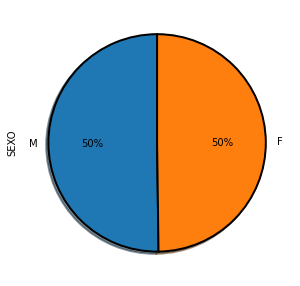

In [147]:
test_categorical("SEXO", add=True)

### Reputación cliente

Variable categórica que clasifica los clientes dentro de cinco grupos, en donde el número 1 etiqueta a los clientes de peor "REPUTACION" y el número 5 denota los de mejor "REPUTACION". Se evidencia que las categorías están equilibradas y no tiene valores perdidos asociados. Se incluye en el modelo

Valores perdidos REPUTACION_CLIENTE = 0


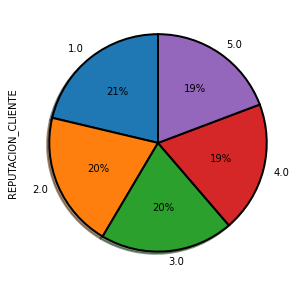

In [148]:
test_categorical("REPUTACION_CLIENTE", add=True)

### Garantia colateral Cliente

La distribución de la variable es uniforme y además no se encuentran valores perdidos 

Valores perdidos GARANTIA_COLATERAL_CLIENTE = 0


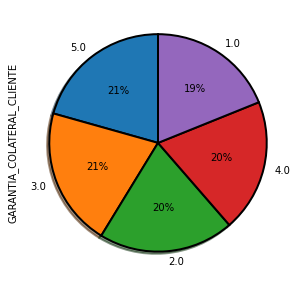

In [149]:
test_categorical("GARANTIA_COLATERAL_CLIENTE", add=True)

### Nivel Riesgo cliente

Valores perdidos NIVEL_RIESGO_CLIENTE = 0


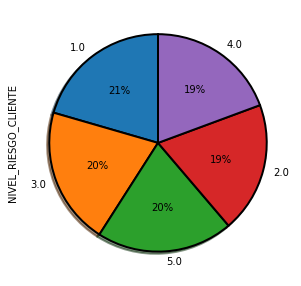

In [150]:
test_categorical("NIVEL_RIESGO_CLIENTE", add=True)

### Capacidad cliente

Valores perdidos CAPACIDAD_CLIENTE = 0


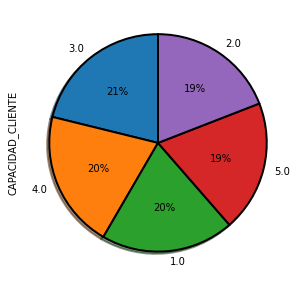

In [151]:
test_categorical("CAPACIDAD_CLIENTE", add=True)

### Capital Cliente

Valores perdidos CAPITAL_CLIENTE = 0


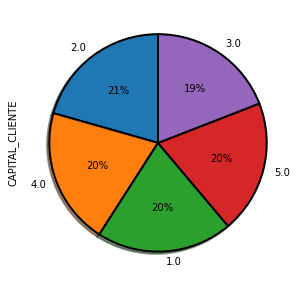

In [152]:
test_categorical("CAPITAL_CLIENTE", add=True)

### Ubicación 

Valores perdidos PROVINCIA_ESTADO_DEPARTAMENTO = 0


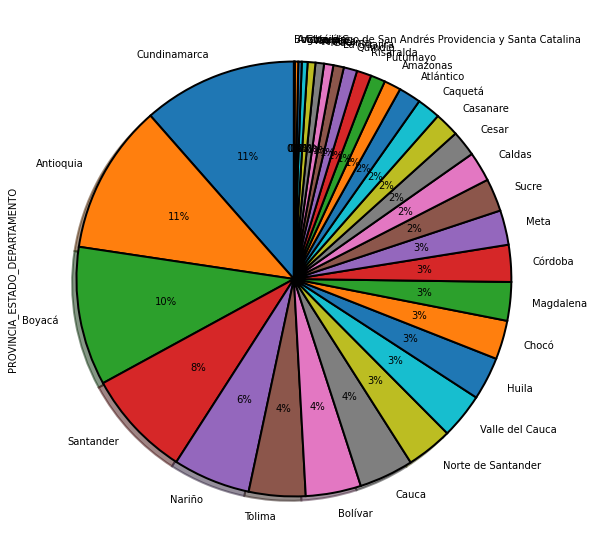

In [153]:
test_categorical("PROVINCIA_ESTADO_DEPARTAMENTO", 10, 10, True)

### Ciudad

Se tiene el nombre de la ciudad del cliente, podría ser provechosa esta información para dotar al sistema de discriminación geográfica hasta el nivel de resolución de ciudad , sin embargo, la complejidad del sistema puede incrementarse, veamos cuantas ciudades se listan en la base de datos 

In [154]:
data_model["CIUDAD"].value_counts()


Nariño                728
San Francisco         699
El Peñón              666
Bolívar               665
La Unión              663
                     ... 
El Cocuy                8
La Jagua del Pilar      6
Belmira                 4
Timbío                  3
Barranquilla            3
Name: CIUDAD, Length: 1036, dtype: int64

Se evidencia que se tienen consignadas en la base de datos 1036 ciudades, por tanto a la hora de hacer la codificación se incluirían este numero de columnas en la matriz de entrenamiento. Por el momento no se incluye este modelo para no agregar un calculo de matrices dispersas

In [155]:
data_model = data_model.drop( columns = ["CIUDAD", "REGION"])

### MORA ACTUAL

Valores perdidos EN_MORA_CONTRATO_ACTUALMENTE = 0


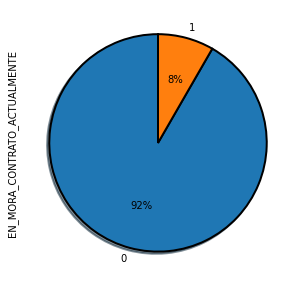

In [156]:
test_categorical("EN_MORA_CONTRATO_ACTUALMENTE")

### Mora Alguna vez

Valores perdidos EN_MORA_CONTRATO_ALGUNA_VEZ = 0


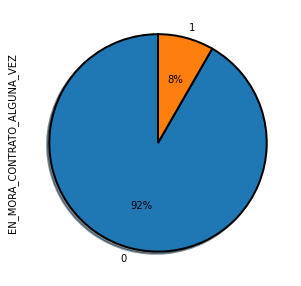

In [157]:
test_categorical("EN_MORA_CONTRATO_ALGUNA_VEZ", add=True)

Lo que necesitamos es algo que parezca una correlación, pero que funcione con valores categóricos, o más formalmente, buscamos una medida de asociación entre dos características categóricas. Presentamos: V de Cramér. Se basa en una variación nominal de la prueba de chi-cuadrado de Pearson y viene incorporada con grandes beneficios:

Se asume una muestra de dos variables dadas por las frecuencias

$$n_{ij} = \text{numero de veces que los valores }(A_{i}, B_{j}) \text{ son observados} $$

Tomando en cuenta la estadística $\chi^{2}$

$$\chi^{2}=\sum_{i,j}\frac{\left(n_{i,j}-\frac{n_{i}n_{j}}{n}\right)^{2}}{\frac{n_{i}n_{j}}{n}}$$

el V de Crámer se calcula tomando la raiz cuadrada de la estadística $\chi^{2}$  dividida por el tamaño de la muestra y la dimensión mínima menos 1

$$V = \sqrt{\frac{\chi^{2}}{n\ \text{min}(k-1, r-1)}}$$

Se define la función que calcula esto

In [158]:
def V(x, y):
    cm = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum().sum()
    phi2 = chi2/n
    r, k = cm.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

La V de Crámer varía de 0 (Correspondiente a ninguna asociación entre variables) a 1 (Asociación completa) y puede llegar a 1 slo cando cada variable está completamente determinada por la otra. $V$ puede verse como la asociaciación entre dos variables como un porcentaje de su máxima variación posible.

In [159]:
var1 = data_model["EN_MORA_CONTRATO_ACTUALMENTE"]
var2 = data_model["EN_MORA_CONTRATO_ALGUNA_VEZ"]
print("Valor de la V. Crámers = {:.3f}".format(V(var1,var2)))

Valor de la V. Crámers = 0.999


Tras la prueba se evidencia que se tiene alta correlación entre estas dos variables categóricas, por tanto solo se elige una de ellas.



### Tipo Identificación 


Valores perdidos TIPO_IDENTIFICACION = 0


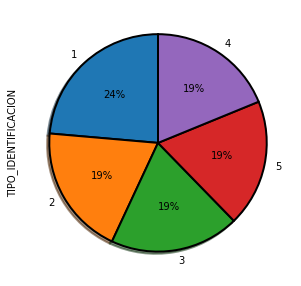

In [160]:
test_categorical("TIPO_IDENTIFICACION", add=True)

Una vez finalizado el análizis de las variables categóricas se eliminan las variables categóricas sin codificar y se incluyen codificadas, lo que resta será el análisis de las variables numericas

In [161]:
data_model = Data_cleaning.encode_categorical_variables(data_model, cat_variables)
data_model

One-Hot encoding ...
 
Elapsed time = 2.85 secs 


,ANIO_CARTERA,MES_CARTERA,ANIOMES_CARTERA,INGRESO,FECHA_INICIO_CONTRATO,PLAZO_PACTADO,CANTIDAD_CUOTAS_PAGADAS,CANTIDAD_CUOTAS_PENDIENTES,PORCENTAJE_INTERES_CORRIENTE_EA,PORCENTAJE_INTERES_MORA_EA,...,PROVINCIA_ESTADO_DEPARTAMENTO_30,PROVINCIA_ESTADO_DEPARTAMENTO_31,PROVINCIA_ESTADO_DEPARTAMENTO_32,EN_MORA_CONTRATO_ALGUNA_VEZ_0,EN_MORA_CONTRATO_ALGUNA_VEZ_1,TIPO_IDENTIFICACION_0,TIPO_IDENTIFICACION_1,TIPO_IDENTIFICACION_2,TIPO_IDENTIFICACION_3,TIPO_IDENTIFICACION_4
0,2018,11,201811,2454284.0,2013-09-23,96.0,61.0,35.0,8.95,18.95,...,0,0,0,1,0,0,0,0,0,1
1,2018,12,201812,5492814.0,2018-08-23,60.0,3.0,57.0,7.45,22.20,...,0,0,0,1,0,0,1,0,0,0
2,2018,12,201812,5946697.0,2016-08-23,84.0,27.0,57.0,15.10,18.95,...,0,0,0,1,0,0,0,1,0,0
3,2018,12,201812,5489184.0,2018-05-23,96.0,6.0,90.0,11.45,18.95,...,0,0,0,1,0,0,0,0,0,1
4,2019,01,201901,5005455.0,2018-03-23,48.0,9.0,39.0,15.10,20.99,...,0,0,0,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182774,2015,07,201507,1806612.0,2014-06-23,96.0,12.0,84.0,10.30,17.45,...,0,0,0,1,0,0,0,1,0,0
182775,2015,07,201507,609600.0,2015-04-23,96.0,2.0,94.0,15.10,18.95,...,0,0,0,1,0,0,0,0,1,0
182776,2015,07,201507,2177628.0,2015-01-23,84.0,5.0,79.0,12.20,20.99,...,0,0,0,1,0,1,0,0,0,0
182777,2015,07,201507,1539082.0,2015-03-23,96.0,3.0,93.0,15.10,18.95,...,0,0,0,1,0,0,1,0,0,0


## Variables numéricas

En primer lugar se revisa la correlación de las variables numéricas para evidenciar si existen variables que duplican la información que aporta la base de datos 


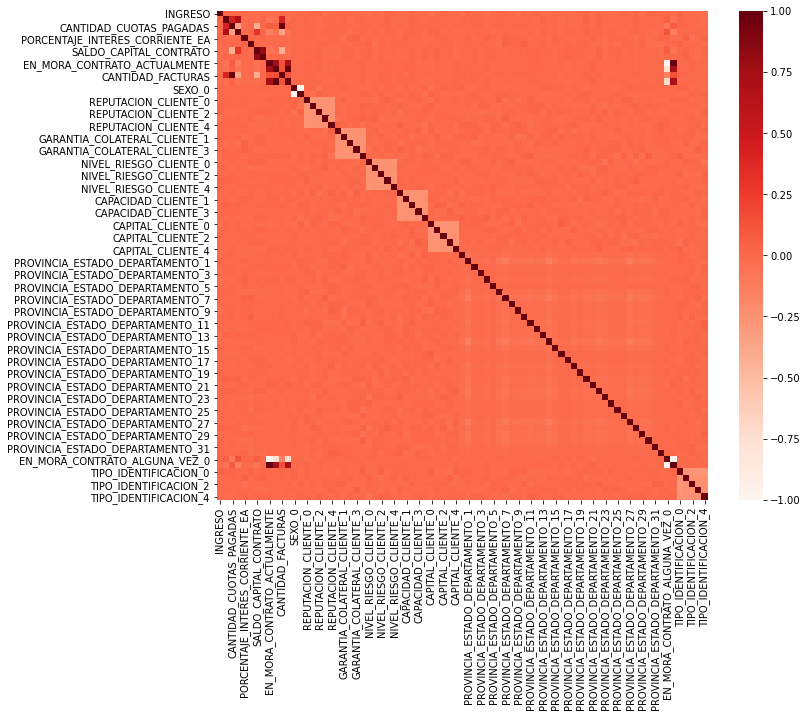

In [162]:
plt.figure(figsize=(11,9))
corr_data = data_model.corr()

sns.heatmap(corr_data , annot=False, cmap=plt.cm.Reds,fmt=".1f")


Se puede evidenciar que exiten variables fuertemente correlacionadas, para poner un límite, se revisan las variables que tengan correlación más alla de 0.7

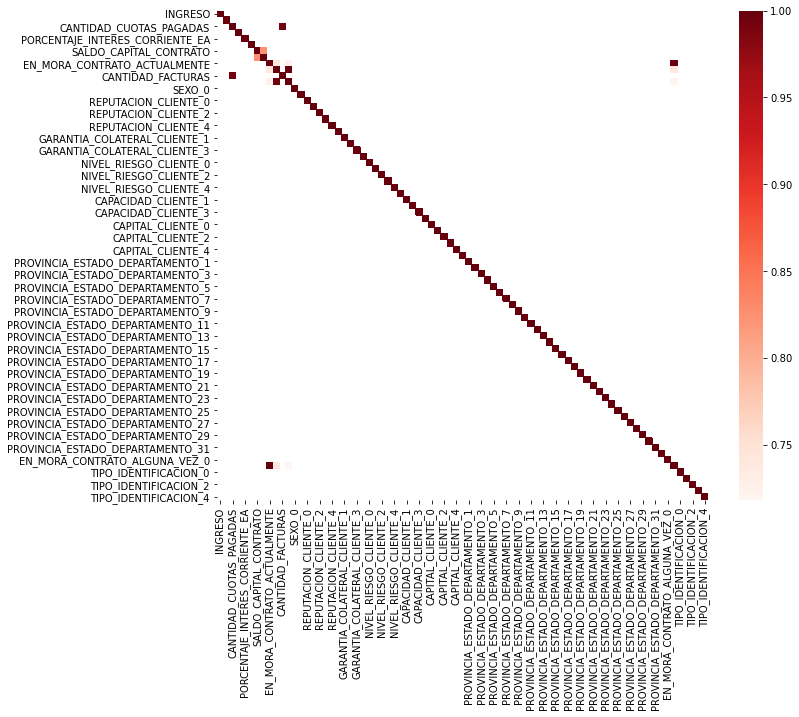

In [163]:
plt.figure(figsize=(11,9))

sns.heatmap(corr_data[corr_data > 0.7] , annot=False, cmap=plt.cm.Reds,fmt=".1f")


### Descarte de variables altamente correlacionadas

Se elige descartar por alta correlación las siguientes variables 

+ CANTIDAD FACTURAS
+ VALOR INICIAL
+ MAXIMA EDAD MORA CONTRATO

In [164]:
data_model = data_model.drop( columns = ["CANTIDAD_FACTURAS", "VALOR_INICIAL", "MAXIMA_EDAD_MORA_CONTRATO"])

### Ingreso 

En la variable ingreso se evidencia que los salarios de los clientes consignados en la base de datos existen en un rango desde 600.000 COP hasta 6.000.000 COP y no existen datos vacios , se incluye dentro del modelo a ajustar 

valores perdidos =  0
rango de ingresos [600210, 5999209]


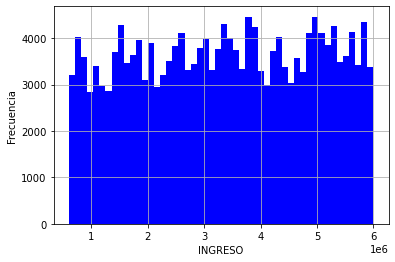

In [165]:
data_model["INGRESO"].hist(bins=50, color="b")
plt.grid(True)
plt.xlabel("INGRESO")
plt.ylabel("Frecuencia")
print("valores perdidos = ", data_model["INGRESO"].isnull().sum())
print("rango de ingresos [{:.0f}, {:.0f}]".format(data_model["INGRESO"].min(), data_model["INGRESO"].max()))

### Plazo pactado

En esta variable se encuentran establecidos nueve plazos, en donde la mayoria de productos que se consignan en la base datos están al mayor plazo, 96 meses. Tampoco se encuentran datos perdidos en eesta variable. Se incluye en el modelo esta variable 

valores perdidos =  0
plazos estipulados
96.0    40371
84.0    38188
72.0    28026
60.0    24974
48.0    19616
36.0    15095
24.0     9810
12.0     4578
6.0      2121
Name: PLAZO_PACTADO, dtype: int64


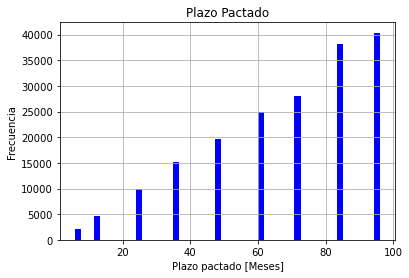

In [166]:
data_model["PLAZO_PACTADO"].hist(bins=50, color = "blue")
plt.xlabel("Plazo pactado [Meses]")
plt.ylabel("Frecuencia")
plt.title("Plazo Pactado")
print("valores perdidos = ", data_model["PLAZO_PACTADO"].isnull().sum())
print("plazos estipulados")
print(data_model["PLAZO_PACTADO"].value_counts())

### Cantidad cuotas pagadas 



valores perdidos =  0


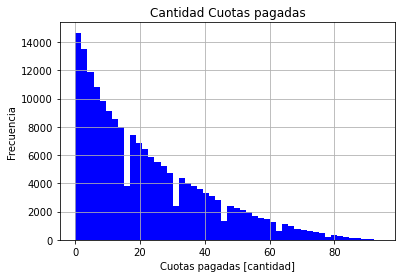

In [167]:
data_model["CANTIDAD_CUOTAS_PAGADAS"].hist(bins=50, color="blue")
plt.xlabel("Cuotas pagadas [cantidad]")
plt.title("Cantidad Cuotas pagadas")
plt.ylabel("Frecuencia")
print("valores perdidos = ", data_model["CANTIDAD_CUOTAS_PAGADAS"].isnull().sum())

### Cantidad cuotas pendientes

valores perdidos =  0


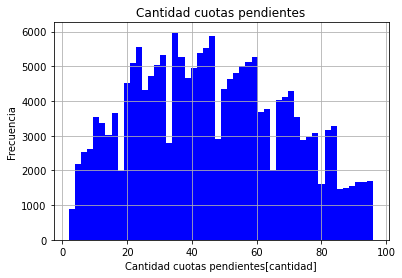

In [168]:
data_model["CANTIDAD_CUOTAS_PENDIENTES"].hist(bins=50, color="blue")
plt.xlabel("Cantidad cuotas pendientes[cantidad]")
plt.ylabel("Frecuencia")
plt.title("Cantidad cuotas pendientes")
print("valores perdidos = ", data_model["CANTIDAD_CUOTAS_PENDIENTES"].isnull().sum())

### Porcentaje interés corriente efectivo anual

valores perdidos =  0
Intereses estipulados
10.99    20791
12.20    20780
15.10    20592
9.12     20480
8.95     20438
7.45     20288
10.30    20206
11.45    19767
9.15     19437
Name: PORCENTAJE_INTERES_CORRIENTE_EA, dtype: int64


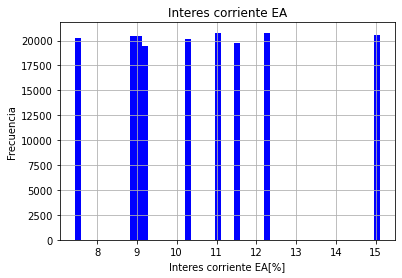

In [169]:
data_model["PORCENTAJE_INTERES_CORRIENTE_EA"].hist(bins=50, color="blue")
plt.xlabel("Interes corriente EA[%]")
plt.ylabel("Frecuencia")
plt.title("Interes corriente EA")
print("valores perdidos = ", data_model["PORCENTAJE_INTERES_CORRIENTE_EA"].isnull().sum())
print("Intereses estipulados")
print(data_model["PORCENTAJE_INTERES_CORRIENTE_EA"].value_counts())


### Saldo Capital contrato

Se evidencia en el histograma que la mayoria de personas deben poco dinero y unas pocas personas deben mucho dinero

737069.0      23
6815962.0     23
274503.0      23
24219116.0    23
7643125.0     23
              ..
33824334.0     1
11113875.0     1
20868649.0     1
21857008.0     1
33554490.0     1
Name: SALDO_CAPITAL_CONTRATO, Length: 167920, dtype: int64

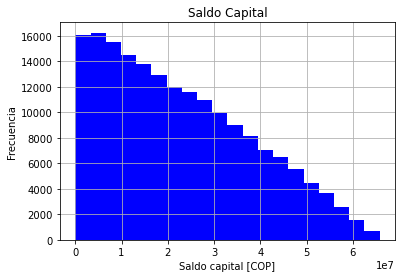

In [170]:
data_model["SALDO_CAPITAL_CONTRATO"].hist(bins=20, color="blue")
plt.xlabel("Saldo capital [COP]")
plt.ylabel("Frecuencia")
plt.title("Saldo Capital")
data_model["SALDO_CAPITAL_CONTRATO"].value_counts()

### Variable Objetivo

Para establecer la variable objetivo se propone hacer una clasificación entre pago y no pago. Si no se tiene información relacionada con la variable __FECHA_PAGO__ se entiende como que no existió pago y que porlo tanto podemos asumir que no existió, de lo contrario si hubo fecha entonces se cataloga como que se hizo efectivo pago.

In [171]:
data_model["PAGO"] =  data_model["FECHA_PAGO"]
data_model["PAGO"] = data_model["PAGO"].fillna(0)
data_model["PAGO"][data_model["PAGO"] !=0 ] = 1

<ipython-input-171-dcc3a767f7ec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model["PAGO"][data_model["PAGO"] !=0 ] = 1


Valores de cada clase
1    172033
0     10746
Name: PAGO, dtype: int64


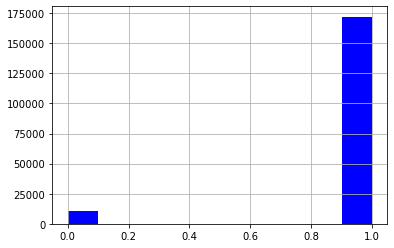

In [172]:
data_model["PAGO"].hist(color="blue")
print("Valores de cada clase")
print(data_model["PAGO"].value_counts())

In [173]:
data_model = data_model.drop(columns=["FECHA_PAGO", "FECHA_RECAUDO", "FECHA_COBRO"])

En principio se hace el análisis sin tener en cuenta la temporalidad de los datos. solo se pretende estudiar el problema asumiendo que clasificamos en clientes que alguna vez no han pagado y los que siempre han pagado

In [174]:
data_model = data_model.drop(columns=["ANIO_CARTERA", "MES_CARTERA", "ANIOMES_CARTERA", "FECHA_INICIO_CONTRATO", "FECHA_REGISTRO_CARTERA"])

para dejar los datos listos se necesita entonces definir concretamente las variables explicativas y las variables objetivo. A continuación se lista las dos


In [175]:
y = data_model["PAGO"].astype('int')
X = data_model.drop(columns=["PAGO"])

print("Tamaño vector variable objetivo      = {}".format(y.shape))
print("Tamaño matriz variables explicativas = {}".format(X.shape))

Tamaño vector variable objetivo      = (182779,)
Tamaño matriz variables explicativas = (182779, 76)


Se hace la separación de los datos en tres conjuntos. Un primer conjunto de entrenamiento para que el modelo aprenda desde esos datos, el segundo grupo es el de testeo y es con el que se ajustan los datos en cada iteración. Por último el conjunto de validación que pretende poner a prueba el rendimiento del modelo bajo algunas métricas establecidas.

In [176]:
X_train, X_test, X_val, y_train, y_test, y_val = split_data.split_stratified(X, y)

print("% de datos en el conjunto de entrenamiento = {:.2f}".format(len(X_train)/len(X)*100))
print("% de datos en el conjunto de validación    = {:.2f}".format(len(X_val)/len(X)*100))
print("% de datos en el conjunto de test          = {:.2f}".format(len(X_test)/len(X)*100))

% de datos en el conjunto de entrenamiento = 60.00
% de datos en el conjunto de validación    = 15.00
% de datos en el conjunto de test          = 25.00


# Modelado Predictivo

El modelado predictivo que se quiere hacer se basa en la siguiente hipótesis. Dado que la pregunta principal que se quiere responder es ¿quién va a pagar? se toma como variable objetivo la variable __FECHA_PAGO__. Esta variable tiene datos del pago efectuado y se asume que cuando no tiene valor es un dato de no pago, en este orden de idea se busca clasificar los clientes que no tengan pago registrado y los que sí. Tomando la siquiente convención

Se define una nueva variable __PAGO__ que es binaria y en la cual el número "0" representa el no pago de la obligación, por el contrario , el número "1" etiqueta las personas que cumplieron con su obligación a satisfacción 

## Modelo de aprendizaje elegido 

Para este ejercicio se elige el XGBoost

In [177]:
params = {"booster":"gbtree", 
          "eta": 0.05, 
          "alpha":0.5,
          "gamma":5,
#           "silent":1,
          "objective":"binary:logistic",
          "eval_metric":"aucroc",
          "colsample_bytree":0.9,
          "subsample":0.8,
          "use_label_encoder":False,
         }

xgb_model = XGBClassifier(**params)

xgb_model.fit(X_train, 
              y_train,
              eval_set=[(X_train, y_train),(X_test, y_test)],
              eval_metric=["error", "auc"],
              early_stopping_rounds=20
             )

[0]	validation_0-error:0.01890	validation_0-auc:0.93910	validation_1-error:0.01954	validation_1-auc:0.93497
[1]	validation_0-error:0.01888	validation_0-auc:0.93925	validation_1-error:0.01911	validation_1-auc:0.93507
[2]	validation_0-error:0.01887	validation_0-auc:0.93935	validation_1-error:0.01919	validation_1-auc:0.93510
[3]	validation_0-error:0.01889	validation_0-auc:0.93944	validation_1-error:0.01893	validation_1-auc:0.93524
[4]	validation_0-error:0.01881	validation_0-auc:0.93962	validation_1-error:0.01891	validation_1-auc:0.93538
[5]	validation_0-error:0.01880	validation_0-auc:0.93963	validation_1-error:0.01893	validation_1-auc:0.93538
[6]	validation_0-error:0.01882	validation_0-auc:0.93969	validation_1-error:0.01913	validation_1-auc:0.93539
[7]	validation_0-error:0.01888	validation_0-auc:0.93973	validation_1-error:0.01913	validation_1-auc:0.93541
[8]	validation_0-error:0.01879	validation_0-auc:0.93978	validation_1-error:0.01913	validation_1-auc:0.93545
[9]	validation_0-error:0.018

XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eta=0.05,
              eval_metric='aucroc', gamma=5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.0500000007,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0.5, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

## Métrica de evaluación

Accuracy:  0.9811430864062443
Recall:    0.9985661693470258
F1-Score:  0.9900678154957449
Precision: 0.9817128924108504
Kappa:     0.8044285989226967


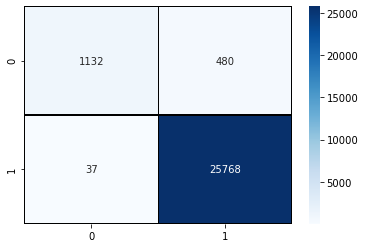

In [178]:
y_pred = xgb_model.predict(X_val)

sns.heatmap(confusion_matrix(y_val, y_pred), 
            annot=True,
            cmap=plt.cm.Blues,
            fmt="g",
            linecolor='black',
            linewidths=0.2
           )

print("Accuracy:  {}".format(accuracy_score(y_val, y_pred)))
print('Recall:    {}'.format(recall_score(y_val, y_pred)))
print('F1-Score:  {}'.format(f1_score(y_val, y_pred)))
print('Precision: {}'.format(precision_score(y_val, y_pred, zero_division="warn")))
print('Kappa:     {}'.format(cohen_kappa_score(y_val, y_pred)))



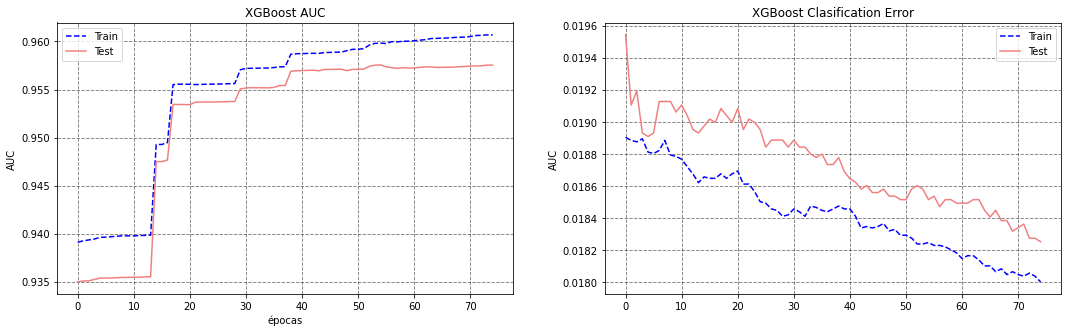

In [179]:
results = xgb_model.evals_result()
epoch   = len(results["validation_0"]["error"])
x_axis  = range(0, epoch)

fig = plt.figure(figsize=(18,5))

plt.subplot(121)
plt.plot(x_axis, results["validation_0"]["auc"], "b--",label="Train")
plt.plot(x_axis, results["validation_1"]["auc"], "lightcoral", label="Test")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("épocas")
plt.title("XGBoost AUC")
plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.9)

plt.subplot(122)
plt.plot(x_axis, results["validation_0"]["error"], "b--",label="Train")
plt.plot(x_axis, results["validation_1"]["error"], "lightcoral",label="Test")
plt.legend()
plt.ylabel("AUC")
plt.title("XGBoost Clasification Error")
plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.9)



## Optimización de hiperparámetros

## Interpretación de modelos de aprendizaje supervisado 

# Resultados

## Resultado de desempeño predictivo

## Resultado del ejercicio de interpretación 

# Discusión y Conclusiones

## Limitaciones y futuras posibles

## Implicaciones prácticas

# Referencias